In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/Projects_sandbox'])
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/Projects_sandbox'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

from Psilocybin.subjects import get_psi_dir

# These are crucial parameters - otherwise all text gets output with each letter in a word or heading as a separate unit
# instead of a text box
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Specify Arial as font type - also crucial
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/xarray/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Specify desired place to plot here.
plot_dir = Path("/Users/nkinsky/University of Michigan Dropbox/Nathaniel Kinsky/Manuscripts/Psilocybin/plots")

## Specify plotting parameters

In [93]:
animals = ["Finn", "Rey", "Rose", "Finn2"]
sessions = ["Saline1", "Psilocybin", "Saline2"]
sessions_full = ["Saline 1", "Psilocybin", "Saline 2"]
rasterize_scatter = True # This is crucial, default (False) will produce unweildy plots

In [178]:
ripple_thresh = 2.5 # 2.5 or 4

# Cut down Finn2 saline to 1hr?
chop_finn2_saline = False  # True = only use 1st hour of Finn2 saline, False = use all
finn2_append = "_1hrsalineonly" if chop_finn2_saline else ""

# ... OR only use 1hr Psilocybin for all
limit_to_1st_hr = False
chop_all_append = "_allsessions1hr" if limit_to_1st_hr else ""
finn2_append = "" if chop_all_append else finn2_append

## Load in data

In [179]:
df_grp = []
for ida, animal in enumerate(animals):
    file_use = get_psi_dir(animal, "Saline1").parent / "aggdata" / f"{animal.lower()}_rpl_features_thresh{'_'.join(str(ripple_thresh).split('.'))}{chop_all_append}.csv"
    df_animal = pd.read_csv(file_use, index_col=0)
    df_animal["Animal_name"] = animal
    df_animal["Animal"] = ida + 1
    df_grp.append(df_animal)

df_grp = pd.concat(df_grp, axis=0, ignore_index=True)
df_grp["session"] = pd.Categorical(df_grp["session"], categories=["Saline 1", "Psilocybin", "Saline 2"])

df_grp
    

,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude,session,Animal_name,Animal
0,0.9184,0.9992,0.9712,8275.3125,0.0808,165.151515,NaN,13.609159,Saline 1,Finn,1
1,1.1328,1.1928,1.1664,11766.3070,0.0600,131.818182,NaN,6.622136,Saline 1,Finn,1
2,31.1544,31.2080,31.1832,8323.5530,0.0536,140.909091,NaN,13.090663,Saline 1,Finn,1
3,60.0312,60.0872,60.0600,8817.6870,0.0560,222.727273,NaN,8.519090,Saline 1,Finn,1
4,64.9136,65.0320,64.9408,11203.7460,0.1184,133.333333,NaN,10.264427,Saline 1,Finn,1
...,...,...,...,...,...,...,...,...,...,...,...
33666,11522.9824,11523.1712,11523.0392,25024.7540,0.1888,130.303030,NaN,14.236207,Saline 2,Finn2,4
33667,11524.8296,11524.9592,11524.9136,28014.1000,0.1296,128.787879,NaN,10.688681,Saline 2,Finn2,4
33668,11525.4064,11525.5128,11525.4480,65397.4600,0.1064,116.666667,NaN,16.468991,Saline 2,Finn2,4
33669,11525.7344,11525.8344,11525.8032,20175.9240,0.1000,118.181818,NaN,7.687241,Saline 2,Finn2,4


In [180]:
df_grp.groupby(["Animal", "session"]).count()

start  stop  peak_time  peak_power  duration  \
Animal session                                                    
1      Saline 1     1356  1356       1356        1356      1356   
       Psilocybin   3310  3310       3310        3310      3310   
       Saline 2     1148  1148       1148        1148      1148   
2      Saline 1     1019  1019       1019        1019      1019   
       Psilocybin   2723  2723       2723        2723      2723   
       Saline 2     2334  2334       2334        2334      2334   
3      Saline 1     1591  1591       1591        1591      1591   
       Psilocybin   2078  2078       2078        2078      2078   
       Saline 2     2203  2203       2203        2203      2203   
4      Saline 1     5303  5303       5303        5303      5303   
       Psilocybin   7237  7237       7237        7237      7237   
       Saline 2     3369  3369       3369        3369      3369   

                   peak_frequency_bp  label  sharp_wave_amplitude  Animal_name  
Animal session                                                                  
1      Saline 1                 1356      0                  1356         1356  
       Psilocybin               3310      0                  3310         3310  
       Saline 2                 1148      0                  1148         1148  
2      Saline 1                 1019      0                  1019         1019  
       Psilocybin               2723      0                  2723         2723  
       Saline 2                 2334      0                  2334         2334  
3      Saline 1                 1591      0                  1591         1591  
       Psilocybin               2078      0                  2078         2078  
       Saline 2                 2203      0                  2203         2203  
4      Saline 1                 5303      0                  5303         5303  
       Psilocybin               7237      0                  7237         7237  
       Saline 2                 3369      0                  3369         3369

In [181]:
# Adjust injection times to 0 = injection time
for animal in animals:
    for session, session_full in zip(sessions, sessions_full):
        inj_file = get_psi_dir(animal, session)
        inj_epochs = Epoch(epochs=None, file=sorted(inj_file.glob("*.injection.npy"))[0])
        inj_time = inj_epochs["POST"].starts[0]
        sesh_bool = (df_grp.Animal_name == animal) & (df_grp.session == session_full)
        df_grp.loc[sesh_bool, "start"] = df_grp.loc[sesh_bool, "start"] - inj_time
        df_grp.loc[sesh_bool, "stop"] = df_grp.loc[sesh_bool, "stop"] - inj_time
        df_grp.loc[sesh_bool, "peak_time"] = df_grp.loc[sesh_bool, "peak_time"] - inj_time

In [182]:
df_mean = df_grp.groupby(["Animal", "session"]).mean(numeric_only=True).reset_index()
# df_mean["session"] = pd.Categorical(df_mean["session"], categories=["Saline 1", "Psilocybin", "Saline 2"])
df_mean

,Animal,session,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude
0,1,Saline 1,1897.440834,1897.569530,1897.505992,10639.255695,0.128696,145.003129,NaN,5.629058
1,1,Psilocybin,4844.255777,4844.359631,4844.308842,9374.057450,0.103853,138.436785,NaN,5.227718
2,1,Saline 2,1049.526244,1049.625710,1049.577504,12377.208752,0.099466,140.781069,NaN,5.731728
3,2,Saline 1,1260.822826,1260.916462,1260.869781,9215.319899,0.093635,135.776311,NaN,6.842761
4,2,Psilocybin,2406.327033,2406.441411,2406.385077,7963.993493,0.114378,136.078189,NaN,6.640374
5,2,Saline 2,2321.362042,2321.456931,2321.411303,9470.534689,0.094889,136.480486,NaN,7.037426
6,3,Saline 1,750.129044,750.227462,750.179181,9563.031675,0.098418,140.747195,NaN,7.274861
7,3,Psilocybin,598.403834,598.517191,598.460430,98111.866444,0.113357,165.624727,NaN,4.538740
8,3,Saline 2,815.713417,815.821575,815.767593,11635.613748,0.108158,145.237899,NaN,6.242752
9,4,Saline 1,5051.729153,5051.836572,5051.783108,21892.591282,0.107419,134.881056,NaN,4.597072


### Plot ripple features over time!

#### TODOs for this plot
1) Use only POST times, will require a bit of upfront work or post-hoc subtraction of the injection time.
2) Figure out why there is a peak for Saline1 at 2000 sec and Saline2 at the end - sleep?

In [148]:
bin_size = 60

bins = np.arange(np.floor(df_grp.peak_time.min() / bin_size) * bin_size, df_grp.stop.max() + bin_size, bin_size).astype(int)
idb = pd.cut(df_grp.peak_time, bins, labels=False)
df_grp["Time bin (sec)"] = bins[idb]
df_grp

,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude,session,Animal_name,Animal,Time bin (sec)
0,0.91840,0.99920,0.97120,8275.3125,0.0808,165.151515,NaN,13.364659,Saline 1,Finn,1,0
1,69.97440,70.03680,70.00560,31828.8180,0.0624,233.333333,NaN,6.180823,Saline 1,Finn,1,60
2,70.43280,70.51040,70.47360,8196.7070,0.0776,227.272727,NaN,3.513697,Saline 1,Finn,1,60
3,89.46560,89.53200,89.50320,6456.5396,0.0664,157.575758,NaN,6.030679,Saline 1,Finn,1,60
4,120.99600,121.07200,121.04640,5693.2330,0.0760,127.272727,NaN,6.569296,Saline 1,Finn,1,120
...,...,...,...,...,...,...,...,...,...,...,...,...
14151,10517.02202,10517.09882,10517.07162,15023.2740,0.0768,112.121212,NaN,8.826762,Saline 2,Finn2,4,10500
14152,10520.09002,10520.27242,10520.14602,21815.7810,0.1824,137.878788,NaN,8.691295,Saline 2,Finn2,4,10500
14153,10522.71402,10522.84042,10522.77162,25660.7340,0.1264,110.606061,NaN,9.745170,Saline 2,Finn2,4,10500
14154,10533.45722,10533.55642,10533.49162,19743.9020,0.0992,125.757576,NaN,20.808641,Saline 2,Finn2,4,10500


<Axes: xlabel='Time bin (sec)', ylabel='duration'>

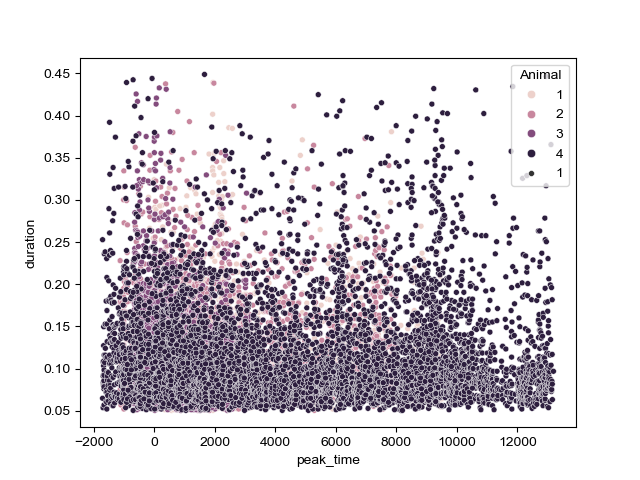

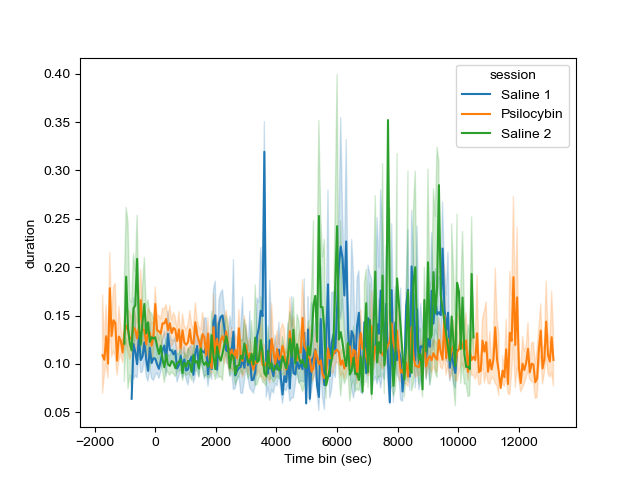

In [149]:
%matplotlib widget
_, ax = plt.subplots()
feature = "duration"
sns.scatterplot(data=df_grp, x = "peak_time", y="duration", hue="Animal", size=1, ax=ax)

_, ax = plt.subplots()
sns.lineplot(data=df_grp, x="Time bin (sec)", y="duration", hue="session", ax=ax)

## Plotting template here with appropriate size graphics and parameters

In [203]:
# Get data for POST sessions only and ONLY including 1 hr of POST
df_post1hr = df_grp[(df_grp.start > 0) & (df_grp.stop < 3600)]
df_post1hr

,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude,session,Animal_name,Animal
0,0.91840,0.99920,0.97120,8275.3125,0.0808,165.151515,NaN,13.609159,Saline 1,Finn,1
1,1.13280,1.19280,1.16640,11766.3070,0.0600,131.818182,NaN,6.622136,Saline 1,Finn,1
2,31.15440,31.20800,31.18320,8323.5530,0.0536,140.909091,NaN,13.090663,Saline 1,Finn,1
3,60.03120,60.08720,60.06000,8817.6870,0.0560,222.727273,NaN,8.519090,Saline 1,Finn,1
4,64.91360,65.03200,64.94080,11203.7460,0.1184,133.333333,NaN,10.264427,Saline 1,Finn,1
...,...,...,...,...,...,...,...,...,...,...,...
31828,3578.48122,3578.56122,3578.51002,41339.2540,0.0800,116.666667,NaN,5.430723,Saline 2,Finn2,4
31829,3580.26362,3580.33882,3580.30362,24703.9450,0.0752,145.454545,NaN,8.875943,Saline 2,Finn2,4
31830,3581.41082,3581.58842,3581.54122,38217.2100,0.1776,118.181818,NaN,12.128832,Saline 2,Finn2,4
31831,3587.08362,3587.16282,3587.13002,15567.9840,0.0792,121.212121,NaN,4.674187,Saline 2,Finn2,4


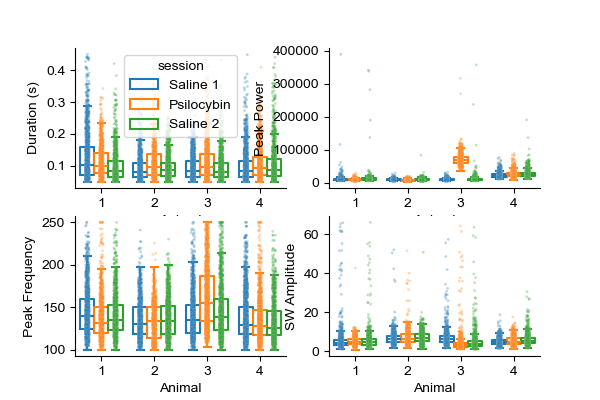

In [205]:
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
titles = ["Duration (s)", "Peak Power", "Peak Frequency", "SW Amplitude"]
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
for idf, feature in enumerate(features):
    ax = axs.reshape(-1)[idf]
    plot_legend = True if idf == 0 else False
    sns.boxplot(data=df_post1hr, x="Animal", y=feature, dodge=True, hue="session", showfliers=False, fill=False, 
                legend=plot_legend, ax=ax)
    sns.stripplot(data=df_post1hr, x="Animal", y=feature, dodge=True, hue="session", size=2, 
                  linewidth=0.1, edgecolor="w", alpha=0.3, rasterized=rasterize_scatter,
                  legend=False, ax=ax)
    ax.set_ylabel(titles[idf])
    sns.despine(ax=ax)

fig.savefig(plot_dir / "ripple_features.pdf", dpi=600)

Alternative plotting method with each animal on different subplots

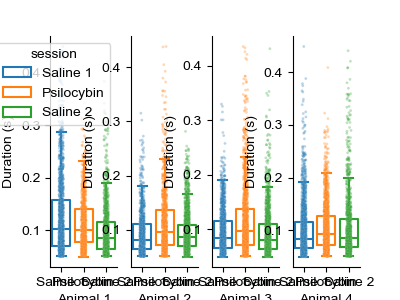

In [209]:
fig, axs = plt.subplots(1, 4, figsize=(4, 3))
idf, feature = 0, "duration"
for ida, animal in enumerate([1, 2, 3, 4]):
    ax = axs.reshape(-1)[ida]
    plot_legend = True if ida == 0 else False
    df_animal = df_post1hr[df_post1hr.Animal == animal]
    sns.boxplot(data=df_animal, x="session", y=feature, hue="session", showfliers=False, fill=False, 
                legend=plot_legend, ax=ax)
    sns.stripplot(data=df_animal, x="session", y=feature, hue="session", size=2, 
                  linewidth=0.1, edgecolor="w", alpha=0.3, rasterized=rasterize_scatter,
                  legend=False, ax=ax)
    ax.set_ylabel(titles[idf])
    ax.set_xlabel(f"Animal {animal}")
    sns.despine(ax=ax)

### Check import of Ilknur's ripple data

In [191]:
ilk_df = pd.read_csv("/Users/nkinsky/Documents/UM/Working/Psilocybin/Recording_Rats/SWR_all_animals_group_data.csv")
ilk_df["session"] = pd.Categorical(ilk_df["session"], ["Saline 1", "Psilocybin", "Saline 2"])
ilk_df

,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude,session,Animal_name,Animal
0,4.40320,4.52000,4.4336,13572.177,0.1168,154.545455,NaN,9.164609,Saline 1,Rey,2
1,5.57920,5.65200,5.6144,16275.078,0.0728,157.575758,NaN,4.701182,Saline 1,Rey,2
2,13.68720,13.74480,13.7248,13655.329,0.0576,178.787879,NaN,5.755942,Saline 1,Rey,2
3,14.19120,14.28880,14.2312,14494.927,0.0976,116.666667,NaN,12.855837,Saline 1,Rey,2
4,15.72880,15.85920,15.7600,14061.571,0.1304,119.696970,NaN,8.396769,Saline 1,Rey,2
...,...,...,...,...,...,...,...,...,...,...,...
17710,10618.47238,10618.60998,9631.9120,14850.061,0.1376,201.515152,NaN,49.487463,Saline 2,Finn2,4
17711,10618.62358,10618.76678,9632.0688,10268.467,0.1432,104.545455,NaN,64.596781,Saline 2,Finn2,4
17712,10619.48678,10619.86998,9632.9944,22503.896,0.3832,133.333333,NaN,96.184643,Saline 2,Finn2,4
17713,10619.89398,10620.03318,9633.2792,10659.393,0.1392,186.363636,NaN,83.187422,Saline 2,Finn2,4


In [169]:
ilk_df[(ilk_df.Animal_name == "Rose") & (ilk_df.session == "Saline 1")]

,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude,session,Animal_name,Animal
9330,686.770187,686.837387,9.1976,14214.547,0.0672,171.212121,NaN,9.035570,Saline 1,Rose,3
9331,687.766187,687.821387,10.1872,20234.578,0.0552,122.727273,NaN,5.847860,Saline 1,Rose,3
9332,730.542987,730.613387,52.9704,10386.981,0.0704,142.424242,NaN,4.250664,Saline 1,Rose,3
9333,772.787787,772.903787,95.2488,12885.894,0.1160,125.757576,NaN,6.848519,Saline 1,Rose,3
9334,776.048587,776.114187,98.4792,10259.733,0.0656,140.909091,NaN,5.277417,Saline 1,Rose,3
...,...,...,...,...,...,...,...,...,...,...,...
9520,3358.699787,3358.806187,2681.1472,16036.420,0.1064,119.696970,NaN,44.634354,Saline 1,Rose,3
9521,3359.450987,3359.642187,2681.9592,8163.306,0.1912,113.636364,NaN,46.629747,Saline 1,Rose,3
9522,3359.812587,3359.952587,2682.2984,12505.428,0.1400,119.696970,NaN,25.203886,Saline 1,Rose,3
9523,3359.955787,3360.029387,2682.3880,14425.804,0.0736,122.727273,NaN,58.543870,Saline 1,Rose,3


In [188]:
df_post1hr[(df_post1hr.Animal_name == "Rose") & (df_post1hr.session == "Saline 1")]

,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude,session,Animal_name,Animal
12272,0.421013,0.477813,0.450613,10776.8760,0.0568,112.121212,NaN,4.803011,Saline 1,Rose,3
12273,2.185013,2.251413,2.216213,10959.5760,0.0664,133.333333,NaN,5.257225,Saline 1,Rose,3
12274,2.340213,2.401013,2.375413,8982.6350,0.0608,128.787879,NaN,5.702279,Saline 1,Rose,3
12275,2.485813,2.549013,2.524213,9816.3560,0.0632,142.424242,NaN,4.450344,Saline 1,Rose,3
12276,4.311413,4.385013,4.338613,6587.7446,0.0736,143.939394,NaN,8.608588,Saline 1,Rose,3
...,...,...,...,...,...,...,...,...,...,...,...
13476,2654.318613,2654.385013,2654.342613,7892.7620,0.0664,112.121212,NaN,10.223828,Saline 1,Rose,3
13477,2655.607413,2655.704213,2655.650613,8576.2910,0.0968,133.333333,NaN,9.875810,Saline 1,Rose,3
13478,2664.320213,2664.406613,2664.382613,10418.7210,0.0864,146.969697,NaN,8.592707,Saline 1,Rose,3
13479,2666.019413,2666.116213,2666.086613,11869.1770,0.0968,110.606061,NaN,19.761511,Saline 1,Rose,3


In [192]:
ilk_df.groupby(by=["Animal_name", "session"]).count()

start  stop  peak_time  peak_power  duration  \
Animal_name session                                                    
Finn        Saline 1     1356  1356       1356        1356      1356   
            Psilocybin   1763  1763       1763        1763      1763   
            Saline 2     1148  1148       1148        1148      1148   
Finn2       Saline 1      331   331        331         331       331   
            Psilocybin   6152  6152       6152        6152      6152   
            Saline 2      354   354        354         354       354   
Rey         Saline 1     1019  1019       1019        1019      1019   
            Psilocybin   2273  2273       2273        2273      2273   
            Saline 2     1771  1771       1771        1771      1771   
Rose        Saline 1      195   195        195         195       195   
            Psilocybin     56    56         56          56        56   
            Saline 2     1297  1297       1297        1297      1297   

                        peak_frequency_bp  label  sharp_wave_amplitude  Animal  
Animal_name session                                                             
Finn        Saline 1                 1356      0                  1356    1356  
            Psilocybin               1763      0                  1763    1763  
            Saline 2                 1148      0                  1148    1148  
Finn2       Saline 1                  331      0                   331     331  
            Psilocybin               6152      0                  6152    6152  
            Saline 2                  354      0                   354     354  
Rey         Saline 1                 1019      0                  1019    1019  
            Psilocybin               2273      0                  2273    2273  
            Saline 2                 1771      0                  1771    1771  
Rose        Saline 1                  195      0                   195     195  
            Psilocybin                 56      0                    56      56  
            Saline 2                 1297      0                  1297    1297

In [193]:
df_post1hr.groupby(by=["Animal_name", "session"]).count()

start  stop  peak_time  peak_power  duration  \
Animal_name session                                                    
Finn        Saline 1     1356  1356       1356        1356      1356   
            Psilocybin    970   970        970         970       970   
            Saline 2     1148  1148       1148        1148      1148   
Finn2       Saline 1     1720  1720       1720        1720      1720   
            Psilocybin   1469  1469       1469        1469      1469   
            Saline 2     1125  1125       1125        1125      1125   
Rey         Saline 1     1019  1019       1019        1019      1019   
            Psilocybin    927   927        927         927       927   
            Saline 2     1689  1689       1689        1689      1689   
Rose        Saline 1     1209  1209       1209        1209      1209   
            Psilocybin   1489  1489       1489        1489      1489   
            Saline 2     1309  1309       1309        1309      1309   

                        peak_frequency_bp  label  sharp_wave_amplitude  Animal  
Animal_name session                                                             
Finn        Saline 1                 1356      0                  1356    1356  
            Psilocybin                970      0                   970     970  
            Saline 2                 1148      0                  1148    1148  
Finn2       Saline 1                 1720      0                  1720    1720  
            Psilocybin               1469      0                  1469    1469  
            Saline 2                 1125      0                  1125    1125  
Rey         Saline 1                 1019      0                  1019    1019  
            Psilocybin                927      0                   927     927  
            Saline 2                 1689      0                  1689    1689  
Rose        Saline 1                 1209      0                  1209    1209  
            Psilocybin               1489      0                  1489    1489  
            Saline 2                 1309      0                  1309    1309